# Face-Mask-Classification Project


Authors:
+ Tobias Palmowski
+ Fabian Metz
+ Thilo Sander

Date of Midterm-Report: 29.03.2021 <br>
Date of final submission: 26.04.2021


### Introduction

This Jupyter Notebook is the core of the Face-Mask-Classification Project performed in the class "Machine Learning" of the Hertie School in Berlin. There is one other Jupyter Notebook which deals with combining the different datasets into one large data set - a task only performed once and therefore outsourced to another file.


### Data Processing: Pipeline-Building

<br>
<br>
<br>
<br>
[Short Description]

In [1]:
# Import necessary libraries and set-up Jupyter NoteMasked-Face-Net-Datasetbook.

# Common imports
import numpy as np
import pandas as pd
import seaborn as sns
import os
import matplotlib.pyplot as plt
import timeit

# Imports for dealing with images:
import PIL #Pillow (install with "pip install Pillow")

# to make this notebook's output stable across runs (safety measure)
np.random.seed(42)

# Set path to correct and incorrect data sets for keeping references short later
ROOT_DATA = "01_data"
PATH_DATA_CORRECT = os.path.join(ROOT_DATA + "/00_raw/Masked-Face-Net-Dataset/CMFD")
PATH_DATA_INCORRECT = os.path.join(ROOT_DATA + "/00_raw/Masked-Face-Net-Dataset/IMFD")

# Where to save figures
ROOT_FIGS = "02_figures"
TOPIC_ID = "02_baseline"
IMAGES_PATH = os.path.join(ROOT_FIGS, TOPIC_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Where to save general output (not figures)
ROOT_OUTPUT = "03_output"
TOPIC_ID = "01_eval_scores"
OUTPUT_PATH = os.path.join(ROOT_OUTPUT, TOPIC_ID)
os.makedirs(OUTPUT_PATH, exist_ok=True)

In [2]:
# Open pickle file that contains the directory
import pickle
pic_data = pickle.load(open(os.path.join(ROOT_DATA + "/01_cleaned/pic_data_full.pkl"),"rb"))

In [3]:
# Copying dictionary data into separate data frames
rgb_data, labels = pic_data["rgb_data"], pic_data["labels"]

In [4]:
# Explore dimensionalities of data frames
print("Dimensions of rgb_data:", rgb_data.shape)
print("Dimensions of labels:", labels.shape)

Dimensions of rgb_data: (133582, 3072)
Dimensions of labels: (133582,)


In [5]:
# Split into test and training data set
from sklearn.model_selection import train_test_split

rgb_data_train, rgb_data_test, labels_train, labels_test = train_test_split(rgb_data, labels, test_size=0.10, random_state=42)

### Evaluating multiple untuned classifiers
<br>
In this section we define an array of initial classifiers and train them on our test data

In [6]:
#import classifiers 
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm, tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier

#define classifiers
classifier_RandomForest = RandomForestClassifier(random_state=42)
classifier_LinSVC = svm.LinearSVC(max_iter=4000, tol=1e-3, random_state=42) #linear as normal (c based) is impractical using large datasets
classifier_DecTree = tree.DecisionTreeClassifier(random_state=42)
classifier_SGD = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
# KNN had several hours runtime an kernel always died before finising
# classifier_KNN = KNeighborsClassifier(n_neighbors=1)
# LogReg hat several hours runtime an kernel always died before finishing
# classifier_LogReg = LogisticRegression(max_iter=2000, tol=1e-3,random_state=42)
classifiers= [classifier_RandomForest,classifier_LinSVC,classifier_DecTree,classifier_SGD]

<div class="alert alert-block alert-danger">
<b>ATTENTION</b>
<p>
Clarify role of max_iterations and possible connectd tradeoffs. Current code specified to produce no errors regarding max_iter
<br>
Clarify wether seed needs to be set individually?
</div>

In [7]:
# redefining labels as True False
labels_train_tf = (labels_train == 1)
labels_test_tf = (labels_test == 1)

In [8]:
# Start total timer
total_start_time = timeit.default_timer()

#intialize arrays and dictionaries 
running = 1
evaluation_scores = {} # dictionary
confusion_matrices = [] 

from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, precision_score, recall_score


#training and evaluating classifiers
for classifier_x in classifiers:
    #Start timer
    loop_start_time = timeit.default_timer()
    
    # Set classifier name and print status
    classifier_name = str(classifier_x) # set classifier names
    classifier_name = classifier_name[:classifier_name.find("(")] 
    print (">... Starting", classifier_name)
    
    #Train model
    classifier_x.fit(rgb_data_train, labels_train_tf) # train
    pred=cross_val_predict(classifier_x, rgb_data_train, labels_train_tf, cv = 3) # cross value prediction with 3 folds
    
    # store evaluation metrics 
    ps = precision_score(labels_train_tf, pred).round(3) 
    rs = recall_score(labels_train_tf, pred).round(3)
    cm = confusion_matrix(labels_train_tf, pred)
    cvs = cross_val_score(classifier_x, rgb_data_train, labels_train_tf, cv=3, scoring="accuracy").round(3)
    cvs_mean = cvs.mean().round(3)
    cvs_std = cvs.std().round(5)
    
    #store confusion matricies in vector
    confusion_matrices.append(cm)
    
    #End timer
    loop_elapsed = timeit.default_timer() - loop_start_time
    
    #store evaluation scores in global dicitonary 
    evaluation_scores[classifier_name]= [ps, rs, cvs, cvs_mean, cvs_std, round(loop_elapsed,2)]
    
    #store evaluation scores in pkl file to access them even when kernel dies afterwards
    file = open(os.path.join(OUTPUT_PATH, "evaluation_scores.pkl"),"wb")
    pickle.dump(evaluation_scores, file)
    file.close()
    
    #Print Status
    print(">...", round(loop_elapsed, 2) ,"seconds run time:", classifier_name)


#End timer
total_elapsed = timeit.default_timer() - total_start_time
print("Classifiers all finished. Run-time: ", round(total_elapsed,2))

>... Starting RandomForestClassifier
>... 1720.01 seconds run time: RandomForestClassifier
>... Starting LinearSVC


/home/thilosander/miniconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/thilosander/miniconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/thilosander/miniconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/thilosander/miniconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/thilosander/miniconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWa

>... 566.44 seconds run time: LinearSVC
>... Starting DecisionTreeClassifier
>... 2365.89 seconds run time: DecisionTreeClassifier
>... Starting SGDClassifier
>... 213.26 seconds run time: SGDClassifier
Classifiers all finished. Run-time:  4865.62


<div class="alert alert-block alert-warning">
<b>ATTENTION</b>
<p>
    
+ Variable running is not necessary or?
+ Let's rewrite this as a function that does the same --> Easier to rerun the stuff later with only the classifiers we want or if you want to rerun a classifier.    
</div>

In [9]:
# creating and printing a table with the  evaluation scores
index = ["precision score", "recall score", "cross validation scores", "cross validation mean", "cross validation std", "run time in seconds"]
table_1 = pd.DataFrame(evaluation_scores, index)
table_1

,RandomForestClassifier,LinearSVC,DecisionTreeClassifier,SGDClassifier
precision score,0.997,0.995,0.993,0.996
recall score,0.998,0.996,0.994,0.997
cross validation scores,"[0.998, 0.997, 0.998]","[0.996, 0.995, 0.995]","[0.994, 0.993, 0.993]","[0.997, 0.996, 0.997]"
cross validation mean,0.998,0.995,0.993,0.997
cross validation std,0.00047,0.00047,0.00047,0.00047
run time in seconds,1720.01,566.44,2365.89,213.26


<div class="alert alert-block alert-danger">
<b>ATTENTION</b>
<p>
Table export needs to be coded. Include Mean and Standard-Deviation of Cross-Evaluation Scores.
</div>

<div class="alert alert-block alert-warning">
<b>ATTENTION</b>
<p>
Below: Hard-coded range is always a very bad idea.
</div>

Saving figure RandomForestClassifier
Saving figure LinearSVC
Saving figure DecisionTreeClassifier
Saving figure SGDClassifier


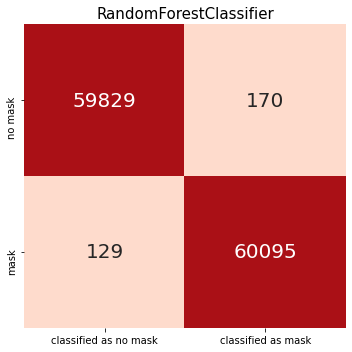

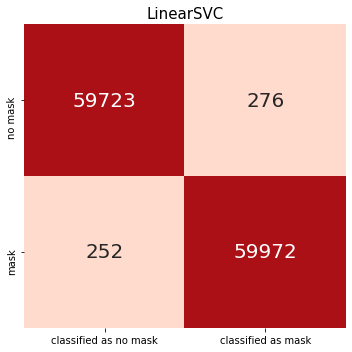

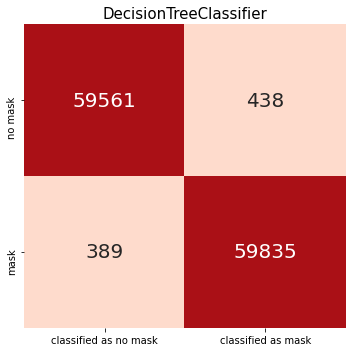

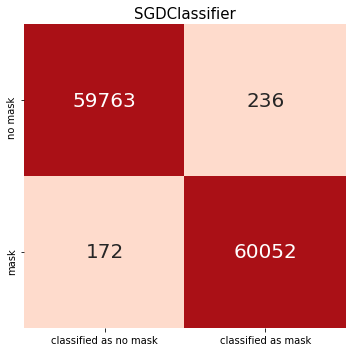

In [10]:
# creating confusion matrices with seaborn heatmaps 
for i in range(len(evaluation_scores)):
    classifier_name = str(classifiers[i]) # set classifier names
    classifier_name = classifier_name[:classifier_name.find("(")] 
    matrix = pd.DataFrame(confusion_matrices[i], columns = ["classified as no mask", "classified as mask"],
                                    index = ["no mask", "mask"])
    
    # Actual plot
    plt.figure(figsize = (5,5))
    colormap = sns.color_palette("Reds")
    ax = plt.axes()
    sns.heatmap(matrix, ax = ax, annot = True, fmt='d', annot_kws={"size": 20}, cmap=colormap, cbar=False)
    ax.set_title(classifier_name, fontsize= 15)
    save_fig("{}".format(classifier_name))


<div class="alert alert-block alert-danger">
<b>ATTENTION</b>
<p>
Figures need to be improved regarding:
    - fontsize
    - figure label
    - positioning axis labels
    - colour?
    
Figure export needs to be coded.
</div>